# Clickstream Personalization with Sequence Learning
Your goal is to predict outcomes of online browsing sessions through session-level-features or sequence of page visits to predict if the next sequence of events/session outcome will be a purchase or not. Working off session level data is definitely more error prone than on a journey level, but it provides the opportunity to initiate nudge models/coupons to help personalize at each session level.

Models used in this assignment are similar to https://github.com/guillaume-chevalier/seq2seq-signal-prediction/blob/master/seq2seq.ipynb

## You have two major tasks today:


1.   To process raw session level data to generate sequence data/sequence models.
2.   Compare performance of sequence models with session-feature level models.

## Your manager needs your help to answer the following question: 
- Which is the better strategy for session level predictions ther lead to personalization: 
  - a) page visit sequences (less complexity for data pre-process) or
  - b) session-level features (more data avy process)



# Task 0: Getting familiar with the Data!

In [1]:
#Mount the RAW session level data: shopping.pkl
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/drive/MyDrive/fourthbrain/week_10')
!ls

Flask-Tutorial-master
Sequence_Learning_on_Cosmetics_Data_4B_v1_cpm.ipynb
Session_features.pkl
shopping.pkl
Week_10_LSTM_Assignment_IMDB_Sentiment_Analysis_cpm.ipynb


In [3]:
# Import all libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.layers import Bidirectional
from keras.layers import TimeDistributed

In [4]:
#Read and look at the RAW data
data = pd.read_pickle('shopping.pkl')
print('Shape of data=', data.shape)
data.head()

Shape of data= (1500000, 12)


,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,year,month,weekday,hour
0,2019-12-01 00:00:00,remove_from_cart,5712790,1487580005268456287,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019,12,Sunday,0
1,2019-12-01 00:00:00,view,5764655,1487580005411062629,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,2019,12,Sunday,0
2,2019-12-01 00:00:02,cart,4958,1487580009471148064,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,2019,12,Sunday,0
3,2019-12-01 00:00:05,view,5848413,1487580007675986893,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,2019,12,Sunday,0
4,2019-12-01 00:00:07,view,5824148,1487580005511725929,nan,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,2019,12,Sunday,0


So for each unique user_session ID, the data fields that are collected are (product ID, category ID, brand, price, user ID, year, month, weekday, hour and the event (view, cart, remove, purchase). Each event is time tagged!

In [5]:
#Next lets look at the feature-level session data
feat = pd.read_pickle('Session_features.pkl')
print('Shape of data=', feat.shape)
feat.head()

Shape of data= (1500000, 36)


,TotalEventsInSession,interactionTime,#TimesCartedinSession,#TimesViewedinSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtViewedInSession,#BrandsCartedInSession,#BrandsViewedInSession,#CategoriesCartedInSession,#CategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,#ProdsCartedInSession,#ProdsViewedInSession,Fr,Mon,Sat,Sun,Thu,Tue,Wed,2019,Nov,Oct,Sep,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Weekend,Purchase
0,7,493.0,0,7,1349.46,131.53,0.00,812.941429,0,7,0,7,145.095000,187.166429,0,7,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0
1,18,585.0,1,16,1747.79,152.58,289.52,621.671250,1,16,1,16,461.202273,653.235432,1,16,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1
2,1,0.0,0,1,1422.10,1422.10,0.00,1422.100000,0,1,0,1,0.000000,625.779478,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0
3,1,0.0,0,1,308.63,308.63,0.00,308.630000,0,1,0,1,0.000000,609.110000,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0
4,11,509.0,4,6,171.90,131.51,171.90,158.220000,4,6,4,6,153.899000,150.426207,4,6,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1


## 1.5M session-level records are given to you. Your goal is to find which data set is best for session-level "purchase" classification!

# Task 1: Generate Data models out of sequence data per session. 
Here, sequence of events (view, cart, remove, purchase) are to be generated per session to see if the sequences just by themselves can indicate if a purchase would occur by the end of the session or not!
This work is the modification from the paper: https://arxiv.org/ftp/arxiv/papers/2010/2010.02503.pdf

## Step 1: Create sequence data per session

In [6]:
# Convert the Events to numeric sequences
events = {'purchase':1,'cart': 2,'view': 3, 'remove_from_cart':4}
data['event'] = data.event_type.map(events)

In [7]:
# Sort the events by 'event time'
data = data.sort_values('event_time')
data.head()

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,year,month,weekday,hour,event
0,2019-12-01 00:00:00,remove_from_cart,5712790,1487580005268456287,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019,12,Sunday,0,4
1,2019-12-01 00:00:00,view,5764655,1487580005411062629,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,2019,12,Sunday,0,3
2,2019-12-01 00:00:02,cart,4958,1487580009471148064,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,2019,12,Sunday,0,2
3,2019-12-01 00:00:05,view,5848413,1487580007675986893,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,2019,12,Sunday,0,3
4,2019-12-01 00:00:07,view,5824148,1487580005511725929,nan,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,2019,12,Sunday,0,3


Next, pre-process the data to extract a Purchase (event=1) or not (event>1) label.

In [8]:
sequence = data.groupby('user_session')['event'].apply(list)
sequence = sequence.reset_index()
sequence['purchase'] = sequence['event'].apply(lambda x: 1 if 1 in x else 0)
sequence = sequence[sequence['event'].map(len)> 1]

In [9]:
#The sequence data should not contain the "purchase field" so it is filtered out
sequence['event']= sequence.event.apply(lambda row: list(filter(lambda a: a != 1, row)))
print('Total number of records=', sequence.shape[0])
sequence.head()

Total number of records= 119480


,user_session,event,purchase
2,00018d32-afba-4db8-9d3d-562c83580579,"[3, 2]",0
4,0001d956-e104-487b-a045-3864d7b9a022,"[2, 2, 2, 2, 2, 2, 2]",0
5,0001ebd4-441d-4c2f-a888-929a63b2afe3,"[3, 3, 3, 3, 3, 3, 3, 3]",0
7,00027027-c51e-4b8f-82bc-0122b3d44204,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, ...",0
9,0002b72e-c9b0-4b2e-99c8-a6c8630c4cfe,"[2, 3, 2, 2, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, ...",0


# So 'sequence' represents data regarding per-session browsing sequence.
But what does an average sequence look like? Can some sequences be specifically long and others be too short? Lets analyze...

In [10]:
#Find the length of events per user-session
length = sequence['event'].map(len).to_list()

In [11]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


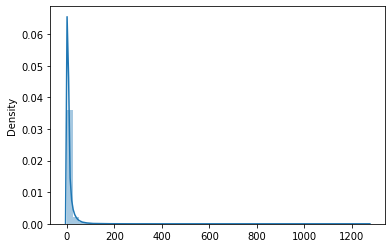

In [13]:
sns.distplot(length)

# So we see, most sequences are about 100 or shorter. 
One major task is to find the optimal sequence size for highest prediction accuracy. Let's try for small and large sequence sizes to find the difference!
# Step 2: Lets analyze up to size 10 sequences and up to size 100 sequences separately!

In [14]:
# select all sequences that are up to 10 events long. Discard remaining sequences.
short_sequence_10 = sequence[sequence['event'].map(len) <= 10]

In [15]:
#Let's see how many records come up
short_sequence_10

,user_session,event,purchase
2,00018d32-afba-4db8-9d3d-562c83580579,"[3, 2]",0
4,0001d956-e104-487b-a045-3864d7b9a022,"[2, 2, 2, 2, 2, 2, 2]",0
5,0001ebd4-441d-4c2f-a888-929a63b2afe3,"[3, 3, 3, 3, 3, 3, 3, 3]",0
10,0002ba44-8b73-4ace-b7c8-fe946aa63cc2,"[3, 2, 2]",0
17,0003d895-8dd0-47c2-94e0-92f7a9031c74,"[3, 3]",0
...,...,...,...
336954,fffb5277-899a-46d8-b51e-2c1f61880f4e,"[3, 2]",0
336963,fffcec5a-c2e3-4e13-8f40-a63f7d14c81f,"[4, 4]",0
336965,fffd3d91-5734-42ac-b149-7403417ec3e2,"[3, 3, 3, 3, 3]",0
336966,fffd5100-6389-486d-8732-9066c47f7ba1,"[3, 3, 2, 3, 3]",0


# Now that you have the limited sequence data, create a data model for it.
# Step 3: Fitting data models: Simple RNN, GRU, LSTM to predict sessions that have a 'purchase' in them.

Apply 70/30 split to data and implement sequence models

In [16]:
event_sequence = short_sequence_10['event'].to_list()

In [17]:
# Pad all sequences with zeros so all inputs have same consistent size of 10
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
event = pad_sequences(event_sequence)

In [18]:
# One Hot Encoding the Purchase label
y = np.array(pd.get_dummies(short_sequence_10['purchase'],prefix='Purchase'))
z=np.sum(y[:,1])/len(y)
print('Percentage of Purchase sessions=',z*100)

Percentage of Purchase sessions= 6.487488415199258


In [19]:
#Define a function to generate 70/30 data split followed by data resizing!
def prepare_train_test_data(data,y):
  #input is data[nxd] and Y[nx2], outputs 70/30 split formatted for the sequence models
  X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3)
  #Resizing is necessary since input to sequence models is (1,d)
  X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
  X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
  return (X_train,X_test,y_train,y_test)

In [20]:
X_train, X_test, y_train, y_test=prepare_train_test_data(np.array(event),y)
print(X_train.shape, y_train.shape)

(64200, 1, 10) (64200, 2)


## Finally, train and test a sequence model built using: SimpleRNN, GRU and LSTM and compare results!

In [21]:
#Helper functions for this:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score


def plot_history(history):
  # This function will plot the model fit process
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('acc')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


def evaluate_on_test(X_test, y_test, training_model):
  #This function will evaluate the fit model on test data
  g_preds=training_model.predict_classes(X_test)
  gaccuracy = accuracy_score(y_test[:,1], g_preds)
  print('Accuracy: %f' % gaccuracy)
  # precision tp / (tp + fp)
  gprecision = precision_score(y_test[:,1], g_preds)
  print('Precision: %f' % gprecision)
  # recall: tp / (tp + fn)
  grecall = recall_score(y_test[:,1], g_preds)
  print('Recall: %f' % grecall)
  # f1: 2 tp / (2 tp + fp + fn)
  gf1 = f1_score(y_test[:,1], g_preds)
  print('F1 score: %f' % gf1)


# The following example shows a model designed using Simple RNN. Repeat the same using GRU and LSTM.

In [22]:
from tensorflow.keras.layers import GRU, Embedding, SimpleRNN, Activation
import tensorflow as tf

In [23]:
#This is a simple RNN model
def simple_RNN_model(neurons=40, op=10):
    model = Sequential()
    model.add(SimpleRNN(neurons, return_sequences = True, input_shape = (1,op)))
    model.add(SimpleRNN(2*neurons))
    model.add(Dense(2, activation='softmax'))
    model.compile(
      optimizer=tf.optimizers.Adam(learning_rate=0.0003),
      loss='binary_crossentropy',
      metrics=['acc'])
    return model

In [24]:
#Visualize the Model
tf.keras.backend.clear_session()
RNN_model = simple_RNN_model(neurons=40, op=10)
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1, 40)             2040      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 80)                9680      
_________________________________________________________________
dense (Dense)                (None, 2)                 162       
Total params: 11,882
Trainable params: 11,882
Non-trainable params: 0
_________________________________________________________________


In [25]:
#Fit the model using 80/20 validation split at runtime
r_history = RNN_model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=1000,#atleast 1000 records per epoch
                    validation_split=0.2)

Epoch 1/20
52/52 [==============================] - 3s 14ms/step - loss: 0.5256 - acc: 0.8116 - val_loss: 0.2479 - val_acc: 0.9343
Epoch 2/20
52/52 [==============================] - 0s 5ms/step - loss: 0.2321 - acc: 0.9346 - val_loss: 0.2134 - val_acc: 0.9343
Epoch 3/20
52/52 [==============================] - 0s 4ms/step - loss: 0.2106 - acc: 0.9347 - val_loss: 0.2075 - val_acc: 0.9343
Epoch 4/20
52/52 [==============================] - 0s 5ms/step - loss: 0.2063 - acc: 0.9341 - val_loss: 0.2050 - val_acc: 0.9343
Epoch 5/20
52/52 [==============================] - 0s 5ms/step - loss: 0.2045 - acc: 0.9347 - val_loss: 0.2034 - val_acc: 0.9343
Epoch 6/20
52/52 [==============================] - 0s 5ms/step - loss: 0.2039 - acc: 0.9336 - val_loss: 0.2019 - val_acc: 0.9343
Epoch 7/20
52/52 [==============================] - 0s 5ms/step - loss: 0.2000 - acc: 0.9383 - val_loss: 0.2004 - val_acc: 0.9452
Epoch 8/20
52/52 [==============================] - 0s 5ms/step - loss: 0.1994 - acc: 0.9

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


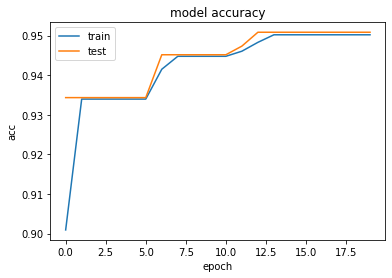

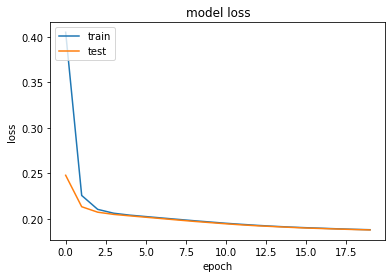

In [26]:
plot_history(r_history)

In [27]:
evaluate_on_test(X_test, y_test, RNN_model)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.952862
Precision: 1.000000
Recall: 0.244172
F1 score: 0.392506


# Task 2: Run GRU and LSTM Models on the 10-sequence data. 
Which is the best model? What is the metric of most importance?


In [28]:
###############START CODE HERE##########################################################################
#Define a GRU model function. Use the simple_RNN_model function and replace the RNN layers with GRU.
#Notice the change in number of parameters
def GRU_model(neurons=40, op=10):
    model = Sequential()
    model.add(GRU(neurons, return_sequences = True, input_shape = (1,op)))
    model.add(GRU(2*neurons))
    model.add(Dense(2, activation='softmax'))
    model.compile(
      optimizer=tf.optimizers.Adam(learning_rate=0.0003),
      loss='binary_crossentropy',
      metrics=['acc'])
    return model

In [29]:
#Visualize the Model (Notice the increase in parameters)
tf.keras.backend.clear_session()
G_model = GRU_model()#neurons=40, op=10)
G_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 40)             6240      
_________________________________________________________________
gru_1 (GRU)                  (None, 80)                29280     
_________________________________________________________________
dense (Dense)                (None, 2)                 162       
Total params: 35,682
Trainable params: 35,682
Non-trainable params: 0
_________________________________________________________________


In [30]:
#Train the G_model (20 epochs, 1000 samples per batch, validation split=0.2)
g_history = G_model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=1000,#atleast 1000 records per epoch
                    validation_split=0.2)

Epoch 1/20
52/52 [==============================] - 5s 15ms/step - loss: 0.5998 - acc: 0.9345 - val_loss: 0.3987 - val_acc: 0.9343
Epoch 2/20
52/52 [==============================] - 0s 5ms/step - loss: 0.3442 - acc: 0.9341 - val_loss: 0.2421 - val_acc: 0.9343
Epoch 3/20
52/52 [==============================] - 0s 5ms/step - loss: 0.2308 - acc: 0.9349 - val_loss: 0.2171 - val_acc: 0.9343
Epoch 4/20
52/52 [==============================] - 0s 5ms/step - loss: 0.2160 - acc: 0.9338 - val_loss: 0.2109 - val_acc: 0.9343
Epoch 5/20
52/52 [==============================] - 0s 5ms/step - loss: 0.2075 - acc: 0.9348 - val_loss: 0.2084 - val_acc: 0.9343
Epoch 6/20
52/52 [==============================] - 0s 5ms/step - loss: 0.2094 - acc: 0.9330 - val_loss: 0.2068 - val_acc: 0.9343
Epoch 7/20
52/52 [==============================] - 0s 5ms/step - loss: 0.2092 - acc: 0.9329 - val_loss: 0.2055 - val_acc: 0.9343
Epoch 8/20
52/52 [==============================] - 0s 5ms/step - loss: 0.2042 - acc: 0.9

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


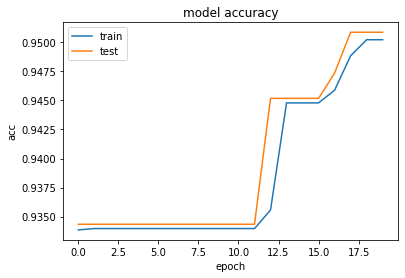

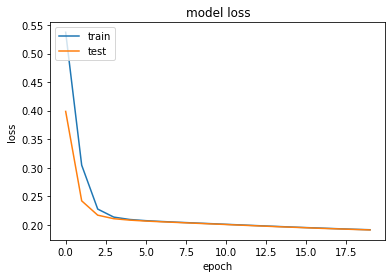

In [31]:
#Use plot_history function to plot the model curves for loss and accuracy
plot_history(g_history)

In [32]:
# Use evaluate_on_test function to note accuracy, precision, recall and F1 score on test data
evaluate_on_test(X_test, y_test, G_model)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.952862
Precision: 1.000000
Recall: 0.244172
F1 score: 0.392506


In [33]:
#Define an LSTM model function. Use the LSTM layer as shown below.
#Notice the change in number of parameters
def LSTM_model(neurons=40, op=10):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, return_sequences=True), input_shape=(1, op)))
    model.add(Bidirectional(LSTM(2*neurons)))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [34]:
tf.keras.backend.clear_session()
training_model = LSTM_model(neurons=40, op=10)
training_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 80)             16320     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 160)               103040    
_________________________________________________________________
dense (Dense)                (None, 2)                 322       
Total params: 119,682
Trainable params: 119,682
Non-trainable params: 0
_________________________________________________________________


In [35]:
#Train the training_model (20 epochs, 1000 samples per batch, validation split=0.2)
lstm_history = training_model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=1000,#atleast 1000 records per epoch
                    validation_split=0.2)

Epoch 1/20
52/52 [==============================] - 6s 28ms/step - loss: 0.6456 - acc: 0.8829 - val_loss: 0.4695 - val_acc: 0.9343
Epoch 2/20
52/52 [==============================] - 0s 8ms/step - loss: 0.3993 - acc: 0.9338 - val_loss: 0.2568 - val_acc: 0.9343
Epoch 3/20
52/52 [==============================] - 0s 8ms/step - loss: 0.2446 - acc: 0.9346 - val_loss: 0.2205 - val_acc: 0.9343
Epoch 4/20
52/52 [==============================] - 0s 7ms/step - loss: 0.2190 - acc: 0.9341 - val_loss: 0.2109 - val_acc: 0.9343
Epoch 5/20
52/52 [==============================] - 0s 7ms/step - loss: 0.2119 - acc: 0.9332 - val_loss: 0.2078 - val_acc: 0.9343
Epoch 6/20
52/52 [==============================] - 0s 7ms/step - loss: 0.2104 - acc: 0.9333 - val_loss: 0.2061 - val_acc: 0.9343
Epoch 7/20
52/52 [==============================] - 1s 12ms/step - loss: 0.2038 - acc: 0.9342 - val_loss: 0.2049 - val_acc: 0.9343
Epoch 8/20
52/52 [==============================] - 0s 8ms/step - loss: 0.2053 - acc: 0.

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


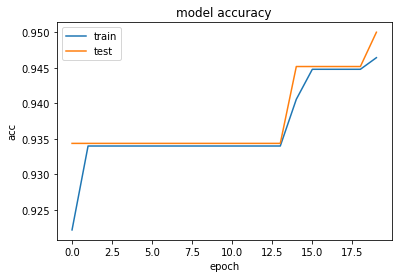

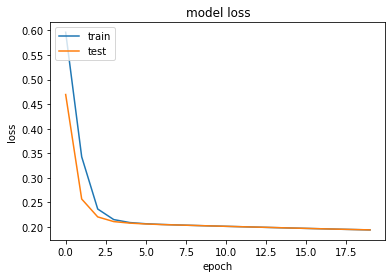

In [36]:
#Use plot_history function to plot the model curves for loss and accuracy
plot_history(lstm_history)

In [37]:
# Use evaluate_on_test function to note accuracy, precision, recall and F1 score on test data
evaluate_on_test(X_test, y_test, training_model)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.951917
Precision: 1.000000
Recall: 0.229021
F1 score: 0.372688


# Task 3: Create sequence data up to size 300. Apply 70/30 split for train-test data.
# Next, fit ONLY the best data model (pick ONE between simple RNN /GRU/ LSTM reported in Task 2) on this data.


In [38]:
#Step 1: Create sequence up to 300
long_sequence_300 = sequence[sequence['event'].map(len) <= 300]
event_sequence_300 = long_sequence_300['event'].to_list()
event_300 = pad_sequences(event_sequence_300)

In [39]:
# One Hot Encoding the Purchase label
y_300 = np.array(pd.get_dummies(long_sequence_300['purchase'], prefix='Purchase'))
X_train_300, X_test_300, y_train_300, y_test_300= prepare_train_test_data(event_300, y_300) # Function call to 'prepare_train_test_data' to create 70/30 split data
print(X_train_300.shape, y_train_300.shape)

(83594, 1, 300) (83594, 2)


### RNN

In [44]:
# Initialize your best model (RNN or GRU or LSTM)
# RNN
tf.keras.backend.clear_session()
RNN_model_long_sequences = simple_RNN_model(neurons=100, op=300) # switching to 300
RNN_model_long_sequences.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1, 100)            40100     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 200)               60200     
_________________________________________________________________
dense (Dense)                (None, 2)                 402       
Total params: 100,702
Trainable params: 100,702
Non-trainable params: 0
_________________________________________________________________


In [45]:
#Fit your model on Training data (20 epochs, 1000 samples per batch, validation_split=0.2)
rnn_long_seq_history = RNN_model_long_sequences.fit(X_train_300, y_train_300,
                    epochs=20,
                    batch_size=1000, #atleast 1000 records per epoch
                    validation_split=0.2)

Epoch 1/20
67/67 [==============================] - 2s 13ms/step - loss: 0.5212 - acc: 0.7043 - val_loss: 0.2792 - val_acc: 0.9059
Epoch 2/20
67/67 [==============================] - 0s 5ms/step - loss: 0.2743 - acc: 0.9072 - val_loss: 0.2730 - val_acc: 0.9059
Epoch 3/20
67/67 [==============================] - 0s 5ms/step - loss: 0.2708 - acc: 0.9066 - val_loss: 0.2704 - val_acc: 0.9059
Epoch 4/20
67/67 [==============================] - 0s 5ms/step - loss: 0.2705 - acc: 0.9052 - val_loss: 0.2690 - val_acc: 0.9059
Epoch 5/20
67/67 [==============================] - 0s 5ms/step - loss: 0.2669 - acc: 0.9060 - val_loss: 0.2672 - val_acc: 0.9059
Epoch 6/20
67/67 [==============================] - 0s 5ms/step - loss: 0.2708 - acc: 0.9083 - val_loss: 0.2660 - val_acc: 0.9140
Epoch 7/20
67/67 [==============================] - 0s 5ms/step - loss: 0.2624 - acc: 0.9154 - val_loss: 0.2646 - val_acc: 0.9139
Epoch 8/20
67/67 [==============================] - 0s 5ms/step - loss: 0.2607 - acc: 0.9

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


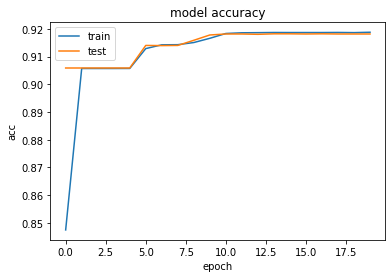

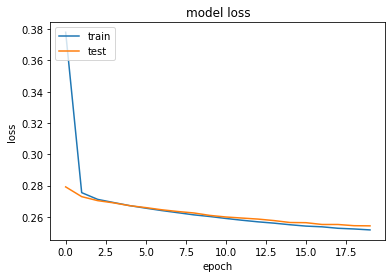

In [46]:
#Use plot_history function to plot the model curves for loss and accuracy
plot_history(rnn_long_seq_history)

In [47]:
# Use evaluate_on_test function to note accuracy, precision, recall and F1 score on test data
evaluate_on_test(X_test_300, y_test_300, RNN_model_long_sequences)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.918551
Precision: 1.000000
Recall: 0.121084
F1 score: 0.216013


### GRU

In [48]:
tf.keras.backend.clear_session()
G_model_long_seq = GRU_model(neurons=100, op=300)
G_model_long_seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 100)            120600    
_________________________________________________________________
gru_1 (GRU)                  (None, 200)               181200    
_________________________________________________________________
dense (Dense)                (None, 2)                 402       
Total params: 302,202
Trainable params: 302,202
Non-trainable params: 0
_________________________________________________________________


In [49]:
#Fit your model on Training data (20 epochs, 1000 samples per batch, validation_split=0.2)
gru_long_seq_history = G_model_long_seq.fit(X_train_300, y_train_300,
                    epochs=20,
                    batch_size=1000, #atleast 1000 records per epoch
                    validation_split=0.2)

Epoch 1/20
67/67 [==============================] - 3s 13ms/step - loss: 0.5354 - acc: 0.9025 - val_loss: 0.3015 - val_acc: 0.9059
Epoch 2/20
67/67 [==============================] - 0s 5ms/step - loss: 0.2915 - acc: 0.9053 - val_loss: 0.2761 - val_acc: 0.9059
Epoch 3/20
67/67 [==============================] - 0s 5ms/step - loss: 0.2750 - acc: 0.9051 - val_loss: 0.2730 - val_acc: 0.9059
Epoch 4/20
67/67 [==============================] - 0s 5ms/step - loss: 0.2738 - acc: 0.9043 - val_loss: 0.2703 - val_acc: 0.9059
Epoch 5/20
67/67 [==============================] - 0s 5ms/step - loss: 0.2733 - acc: 0.9043 - val_loss: 0.2694 - val_acc: 0.9058
Epoch 6/20
67/67 [==============================] - 0s 5ms/step - loss: 0.2651 - acc: 0.9066 - val_loss: 0.2671 - val_acc: 0.9059
Epoch 7/20
67/67 [==============================] - 0s 5ms/step - loss: 0.2676 - acc: 0.9044 - val_loss: 0.2664 - val_acc: 0.9059
Epoch 8/20
67/67 [==============================] - 0s 5ms/step - loss: 0.2663 - acc: 0.9

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


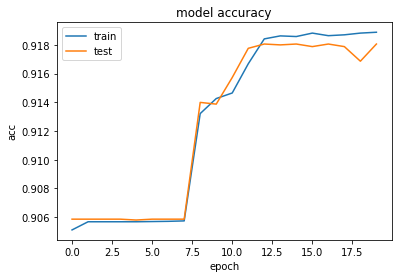

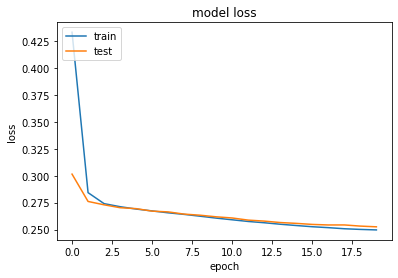

In [50]:
plot_history(gru_long_seq_history)

In [51]:
evaluate_on_test(X_test_300, y_test_300, G_model_long_seq)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.918551
Precision: 0.976303
Recall: 0.124096
F1 score: 0.220203


### LSTM

In [52]:
tf.keras.backend.clear_session()
LSTM_model_long_seq = LSTM_model(neurons=100, op=300)
LSTM_model_long_seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 200)            320800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 400)               641600    
_________________________________________________________________
dense (Dense)                (None, 2)                 802       
Total params: 963,202
Trainable params: 963,202
Non-trainable params: 0
_________________________________________________________________


In [53]:
lstm_long_seq_history = LSTM_model_long_seq.fit(X_train_300, y_train_300,
                    epochs=20,
                    batch_size=1000, #atleast 1000 records per epoch
                    validation_split=0.2)

Epoch 1/20
67/67 [==============================] - 6s 24ms/step - loss: 0.5773 - acc: 0.8459 - val_loss: 0.3067 - val_acc: 0.9059
Epoch 2/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2966 - acc: 0.9034 - val_loss: 0.2736 - val_acc: 0.9059
Epoch 3/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2741 - acc: 0.9053 - val_loss: 0.2697 - val_acc: 0.9059
Epoch 4/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2676 - acc: 0.9070 - val_loss: 0.2683 - val_acc: 0.9059
Epoch 5/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2689 - acc: 0.9055 - val_loss: 0.2676 - val_acc: 0.9059
Epoch 6/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2697 - acc: 0.9033 - val_loss: 0.2659 - val_acc: 0.9059
Epoch 7/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2638 - acc: 0.9062 - val_loss: 0.2647 - val_acc: 0.9059
Epoch 8/20
67/67 [==============================] - 1s 8ms/step - loss: 0.2611 - acc: 0.9

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


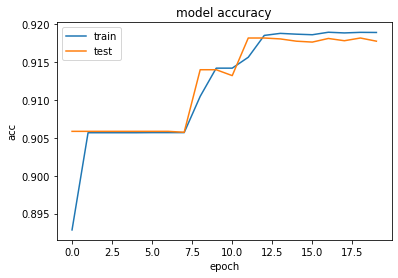

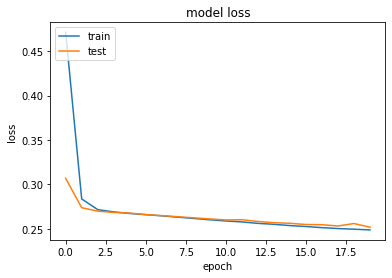

In [54]:
plot_history(lstm_long_seq_history)

In [55]:
evaluate_on_test(X_test_300, y_test_300, LSTM_model_long_seq)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.918551
Precision: 0.946667
Recall: 0.128313
F1 score: 0.225995


# Task 4: Finally apply feature-based classification on the session-feature level data (Session_features.pkl).

Apply your best model so far on 70/30 split data for session-feature level data and report your outcome!

In [56]:
#data=feat, contains X and Y(last column)
Xf=feat.iloc[:,0:34]
Yf=feat.iloc[:,35]
#########################START CODE HERE##########################
Xf_train, Xf_test, yf_train, yf_test= prepare_train_test_data(Xf.to_numpy(), np.array(pd.get_dummies(Yf))) # Function call to 'prepare_train_test_data' to create 70/30 split data
print(Xf_train.shape, yf_train.shape)

(1050000, 1, 34) (1050000, 2)


### RNN

In [57]:
tf.keras.backend.clear_session()
RNN_model_session = simple_RNN_model(neurons=100, op=34)
RNN_model_session.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1, 100)            13500     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 200)               60200     
_________________________________________________________________
dense (Dense)                (None, 2)                 402       
Total params: 74,102
Trainable params: 74,102
Non-trainable params: 0
_________________________________________________________________


In [58]:
#Fit your model on Training data (20 epochs, 1000 samples per batch, validation_split=0.2)
rnn_session_history = RNN_model_session.fit(Xf_train, yf_train,
                    epochs=20,
                    batch_size=1000, #atleast 1000 records per epoch
                    validation_split=0.2)

Epoch 1/20
840/840 [==============================] - 4s 3ms/step - loss: 0.1984 - acc: 0.9270 - val_loss: 0.1545 - val_acc: 0.9356
Epoch 2/20
840/840 [==============================] - 3s 3ms/step - loss: 0.1506 - acc: 0.9374 - val_loss: 0.1433 - val_acc: 0.9390
Epoch 3/20
840/840 [==============================] - 3s 3ms/step - loss: 0.1389 - acc: 0.9411 - val_loss: 0.1365 - val_acc: 0.9410
Epoch 4/20
840/840 [==============================] - 3s 3ms/step - loss: 0.1338 - acc: 0.9427 - val_loss: 0.1301 - val_acc: 0.9437
Epoch 5/20
840/840 [==============================] - 3s 3ms/step - loss: 0.1249 - acc: 0.9472 - val_loss: 0.1082 - val_acc: 0.9582
Epoch 6/20
840/840 [==============================] - 3s 3ms/step - loss: 0.0968 - acc: 0.9648 - val_loss: 0.0817 - val_acc: 0.9725
Epoch 7/20
840/840 [==============================] - 3s 3ms/step - loss: 0.0740 - acc: 0.9749 - val_loss: 0.0678 - val_acc: 0.9774
Epoch 8/20
840/840 [==============================] - 3s 3ms/step - loss: 0.

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


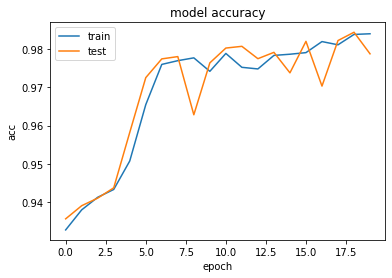

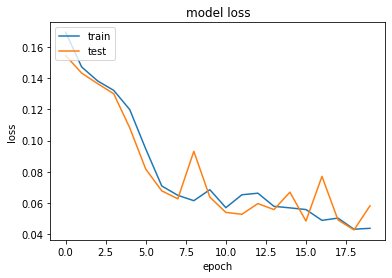

In [59]:
plot_history(rnn_session_history)

In [60]:
evaluate_on_test(Xf_test, yf_test, RNN_model_session)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.978864
Precision: 0.976004
Recall: 0.712010
F1 score: 0.823363


### GRU

In [61]:
tf.keras.backend.clear_session()
GRU_model_session = GRU_model(neurons=100, op=34)
GRU_model_session.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 100)            40800     
_________________________________________________________________
gru_1 (GRU)                  (None, 200)               181200    
_________________________________________________________________
dense (Dense)                (None, 2)                 402       
Total params: 222,402
Trainable params: 222,402
Non-trainable params: 0
_________________________________________________________________


In [62]:
gru_session_history = GRU_model_session.fit(Xf_train, yf_train,
                    epochs=20,
                    batch_size=1000,
                    validation_split=0.2)

Epoch 1/20
840/840 [==============================] - 5s 4ms/step - loss: 0.2081 - acc: 0.9256 - val_loss: 0.1421 - val_acc: 0.9384
Epoch 2/20
840/840 [==============================] - 3s 4ms/step - loss: 0.1378 - acc: 0.9405 - val_loss: 0.1347 - val_acc: 0.9414
Epoch 3/20
840/840 [==============================] - 3s 4ms/step - loss: 0.1302 - acc: 0.9433 - val_loss: 0.1263 - val_acc: 0.9455
Epoch 4/20
840/840 [==============================] - 3s 4ms/step - loss: 0.1223 - acc: 0.9472 - val_loss: 0.1160 - val_acc: 0.9502
Epoch 5/20
840/840 [==============================] - 3s 4ms/step - loss: 0.1097 - acc: 0.9545 - val_loss: 0.0875 - val_acc: 0.9697
Epoch 6/20
840/840 [==============================] - 3s 4ms/step - loss: 0.0798 - acc: 0.9714 - val_loss: 0.0577 - val_acc: 0.9800
Epoch 7/20
840/840 [==============================] - 3s 4ms/step - loss: 0.0571 - acc: 0.9800 - val_loss: 0.0495 - val_acc: 0.9824
Epoch 8/20
840/840 [==============================] - 3s 4ms/step - loss: 0.

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


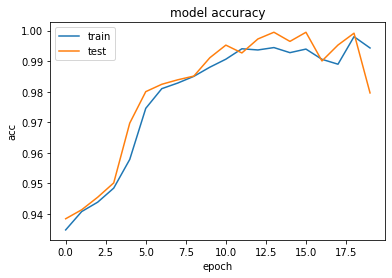

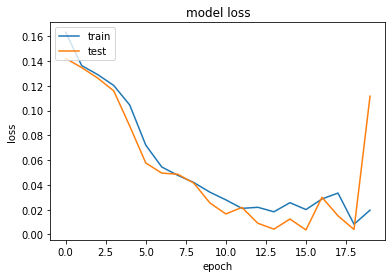

In [63]:
plot_history(gru_session_history)

In [64]:
evaluate_on_test(Xf_test, yf_test, GRU_model_session)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.979836
Precision: 0.868843
Recall: 0.834516
F1 score: 0.851334


### LSTM

In [65]:
tf.keras.backend.clear_session()
LSTM_model_session = LSTM_model(neurons=100, op=34)
LSTM_model_session.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 200)            108000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 400)               641600    
_________________________________________________________________
dense (Dense)                (None, 2)                 802       
Total params: 750,402
Trainable params: 750,402
Non-trainable params: 0
_________________________________________________________________


In [66]:
lstm_session_history = LSTM_model_session.fit(Xf_train, yf_train,
                    epochs=20,
                    batch_size=1000,
                    validation_split=0.2)

Epoch 1/20
840/840 [==============================] - 11s 9ms/step - loss: 0.2098 - acc: 0.9275 - val_loss: 0.1407 - val_acc: 0.9401
Epoch 2/20
840/840 [==============================] - 6s 7ms/step - loss: 0.1346 - acc: 0.9412 - val_loss: 0.1317 - val_acc: 0.9422
Epoch 3/20
840/840 [==============================] - 6s 7ms/step - loss: 0.1207 - acc: 0.9490 - val_loss: 0.1073 - val_acc: 0.9563
Epoch 4/20
840/840 [==============================] - 6s 7ms/step - loss: 0.0966 - acc: 0.9619 - val_loss: 0.0568 - val_acc: 0.9809
Epoch 5/20
840/840 [==============================] - 6s 7ms/step - loss: 0.0538 - acc: 0.9813 - val_loss: 0.0348 - val_acc: 0.9893
Epoch 6/20
840/840 [==============================] - 6s 7ms/step - loss: 0.0386 - acc: 0.9859 - val_loss: 0.0288 - val_acc: 0.9903
Epoch 7/20
840/840 [==============================] - 6s 7ms/step - loss: 0.0369 - acc: 0.9874 - val_loss: 0.0263 - val_acc: 0.9904
Epoch 8/20
840/840 [==============================] - 6s 7ms/step - loss: 0

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


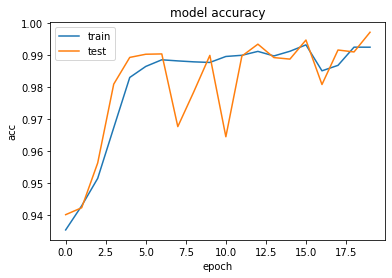

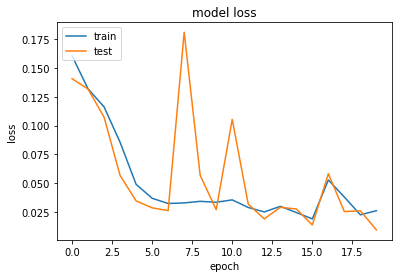

In [67]:
plot_history(lstm_session_history)

In [68]:
evaluate_on_test(Xf_test, yf_test, LSTM_model_session)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.997336
Precision: 0.998701
Recall: 0.962741
F1 score: 0.980391


# Comment on what you would suggest to your manager?


*  Is feature-level data necessary? What metrics suggest that?
  - Yes, in this case feature-level data offers a massive boost in our performance metrics over the sequence-level data. Our best performing LSTM using feature-level data had an F1 score of 0.98 and recall of 0.96. This significantly outperforms the best model trained on sequence data, a simple RNN which achieved an F1 score of 0.39.
*  Is sequence-level data sufficient? What sequence size would you suggest?
  - No, ideally we would use feature-level data, which enabled us to get much better F1 and recall scores. If we only had sequence-level data available, the shorter sequences (10 or less) outperformed the longer ones (300 or less). This would be a great area for further research to determine the best sequence length.

